Epoch 1/10, Loss: 2.0023, Test Accuracy: 0.3535
Epoch 2/10, Loss: 1.8745, Test Accuracy: 0.3730
Epoch 3/10, Loss: 1.8362, Test Accuracy: 0.3805
Epoch 4/10, Loss: 1.8142, Test Accuracy: 0.3893
Epoch 5/10, Loss: 1.7992, Test Accuracy: 0.3921
Epoch 6/10, Loss: 1.7879, Test Accuracy: 0.3938
Epoch 7/10, Loss: 1.7785, Test Accuracy: 0.3952
Epoch 8/10, Loss: 1.7704, Test Accuracy: 0.3971
Epoch 9/10, Loss: 1.7637, Test Accuracy: 0.3970
Epoch 10/10, Loss: 1.7574, Test Accuracy: 0.4011


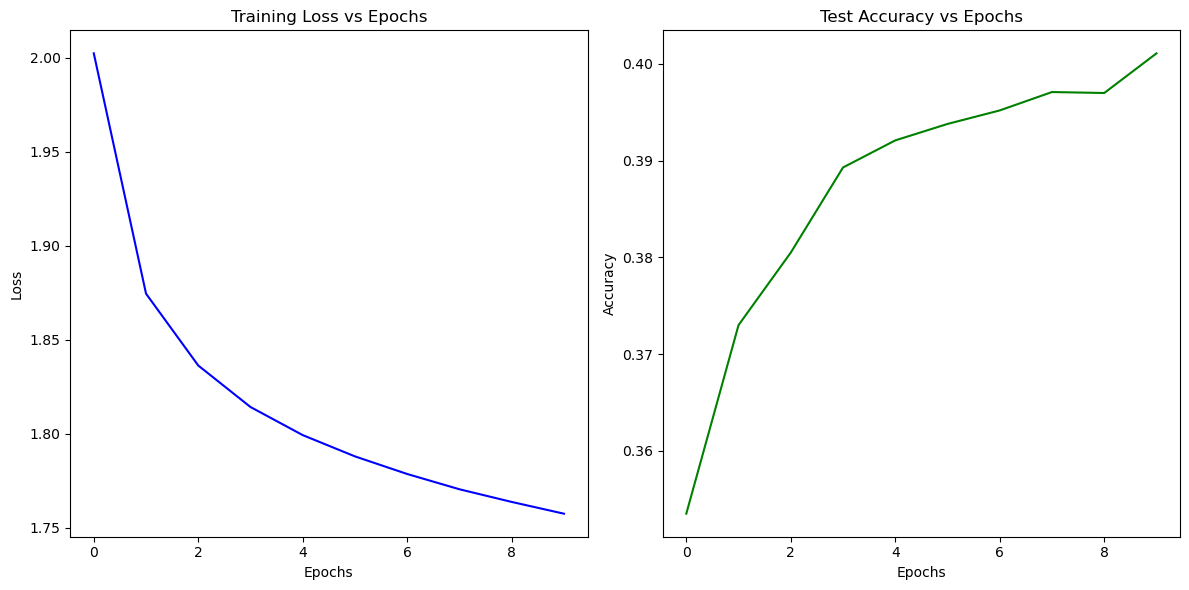

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as npy
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define image transformation (normalizing and converting to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standardization
])

# Load CIFAR-10 training and test datasets with transformations. We are loading the CIFAR dataset here
CifartrainingData = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
Cifartest_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders for batching. We cannot pass the entire dataset at once to the model so we pass chunks of input data to the model for output
# the chunk size is defined here as batch_size. The input training dataset needs to be shuffled well inorder to train the model properly. 
# test dataset need not be shuffled.
train_loader = DataLoader(CifartrainingData, batch_size=64, shuffle=True)
test_loader = DataLoader(Cifartest_data, batch_size=64, shuffle=False)

# THis class is used to define the linear classifier various fucntions included.
# regularization_strength  avoid overfitting
# inputdim => no of input features. and total_classes = total number of classes
class SimpleLinearClassifier:

    # initialises variables.
    def __init__(self, input_dmen, total_classes, regularization_strength=0.0):
        self.weights = npy.random.randn(input_dmen, total_classes) * 0.01  # Initialize weights
        self.bias = npy.zeros((1, total_classes))  # Initialize bias
        self.reg_strength = regularization_strength  # Regularization parameter

    # forward_pass_method -> when input x is given it will prefict outputs for that input x.
    def forward_pass_method(self, input_X):
        return npy.dot(input_X, self.weights) + self.bias  # input * weight + bias

    # logit is the output after applying the linear transformation. score until ativation is applied. can predict linearly
    def lossComputation(self, logits, labels):
        numSamples = logits.shape[0]
        exp_scoreValues = npy.exp(logits - npy.max(logits, axis=1, keepdims=True))  # Stability adjustment
        # probs = predicted probability assessment
        probs = exp_scoreValues / npy.sum(exp_scoreValues, axis=1, keepdims=True)  # Softmax probabilities used to convert logits into probabilities
        # extracts predicted probability of the correct class and then calculates negative log of that probability
        correct_log_prob = -npy.log(probs[npy.arange(numSamples), labels])
        lossValue = npy.sum(correct_log_prob) / numSamples

        # Regularization term (L2)
        regularization = self.reg_strength * npy.sum(self.weights ** 2)
        lossValue += regularization
        return lossValue, probs

    # backpropagation =>  backward function computes gradients 
    def backward_function(self, input_X, probs, labels):
        numSamples = input_X.shape[0]
        grads = probs
        grads[npy.arange(numSamples), labels] -= 1
        grads /= numSamples
        gradWeights = npy.dot(input_X.T, grads)

        # Add regularization gradient
        gradWeights += 2 * self.reg_strength * self.weights

        gradBiasValue = npy.sum(grads, axis=0, keepdims=True)
        return gradWeights, gradBiasValue
    
    def update(self, gradWeights, gradBiasValue, lr):
        self.weights -= lr * gradWeights  # Update weights
        self.bias -= lr * gradBiasValue  # Update bias

# Hyperparameters
input_dmen = 32 * 32 * 3  # Image dimensions (32x32x3)
total_classes = 10  # CIFAR-10 has 10 classes
learning_rate = 0.001
epochs = 10
regularization_strength = 0.001

# Initialize the classifier
classifier = SimpleLinearClassifier(input_dmen, total_classes, regularization_strength)

# Store training loss and test accuracy for plotting
training_losses = []
test_accuracies = []

# Training loop
for epochValue in range(epochs):
    classifier.weights = classifier.weights.astype(npy.float32)  # Ensure float32 type

    epochLossValue = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1).numpy()  # Flatten image batch
        labels = labels.numpy()  # Convert labels to numpy

        # forward_pass_method pass
        logits = classifier.forward_pass_method(images)

        # Compute the loss
        lossValue, probabilities = classifier.lossComputation(logits, labels)
        epochLossValue += lossValue

        # Backward pass
        gradWeights, gradBiasValue = classifier.backward_function(images, probabilities, labels)

        # Parameter update
        classifier.update(gradWeights, gradBiasValue, learning_rate)

    # Record the average loss for the epoch
    training_losses.append(epochLossValue / len(train_loader))

    # Evaluate on test data
    classifier.weights = classifier.weights.astype(npy.float32)  # Consistent dtype
    test_logits = []
    test_labels = []

    for images, labels in test_loader:
        images = images.view(images.size(0), -1).numpy()  # Flatten image batch
        labels = labels.numpy()

        # forward_pass_method pass
        logits = classifier.forward_pass_method(images)
        test_logits.append(logits)
        test_labels.append(labels)

    # Concatenate test results
    test_logits = npy.concatenate(test_logits, axis=0)
    test_labels = npy.concatenate(test_labels, axis=0)

    # Calculate accuracy
    predicted_labels = npy.argmax(test_logits, axis=1)
    accuracy = accuracy_score(test_labels, predicted_labels)
    test_accuracies.append(accuracy)

    # Print epoch statistics
    print(f"Epoch {epochValue+1}/{epochs}, Loss: {epochLossValue / len(train_loader):.4f}, Test Accuracy: {accuracy:.4f}")

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_losses, label='Training Loss', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='g')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


# Hyperparameter Tuning 

In [52]:
### Scenario 1: 

Epoch 1/5, Loss: 43.1041, Test Accuracy: 0.2370
Epoch 2/5, Loss: 41.3646, Test Accuracy: 0.2339
Epoch 3/5, Loss: 41.2814, Test Accuracy: 0.2244
Epoch 4/5, Loss: 41.3153, Test Accuracy: 0.2122
Epoch 5/5, Loss: 41.4163, Test Accuracy: 0.2376


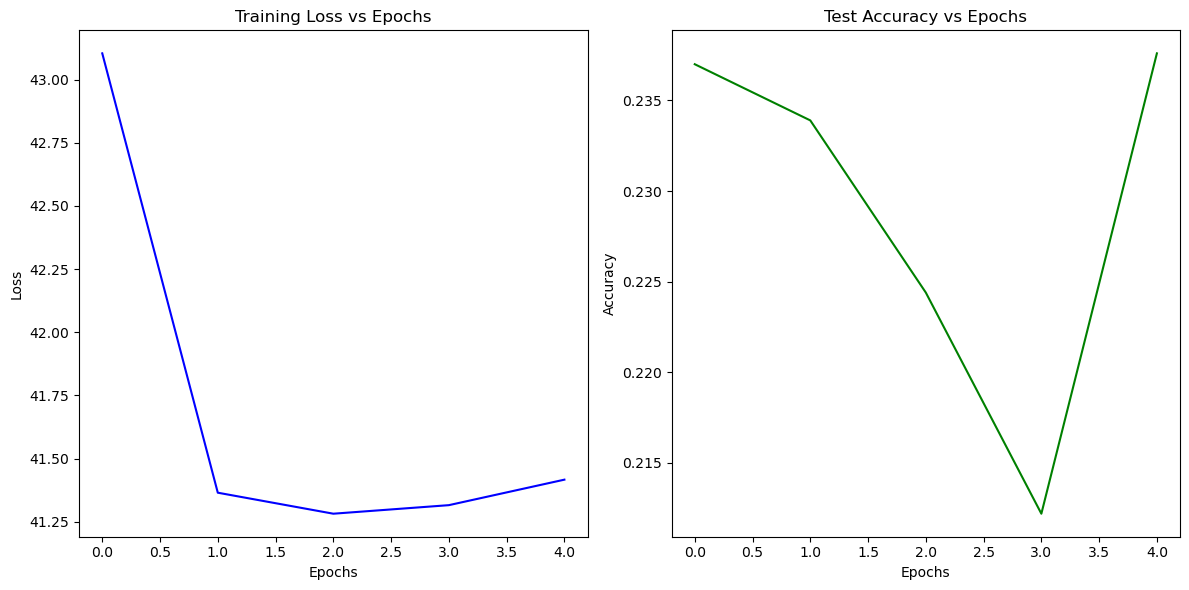

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as npy
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define image transformation (normalizing and converting to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standardization
])

# Load CIFAR-10 training and test datasets with transformations. We are loading the CIFAR dataset here
CifartrainingData = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
Cifartest_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders for batching. We cannot pass the entire dataset at once to the model so we pass chunks of input data to the model for output
# the chunk size is defined here as batch_size. The input training dataset needs to be shuffled well inorder to train the model properly. 
# test dataset need not be shuffled.
train_loader = DataLoader(CifartrainingData, batch_size=64, shuffle=True)
test_loader = DataLoader(Cifartest_data, batch_size=64, shuffle=False)

# THis class is used to define the linear classifier various fucntions included.
# regularization_strength  avoid overfitting
# inputdim => no of input features. and total_classes = total number of classes
class SimpleLinearClassifier:

    # initialises variables.
    def __init__(self, input_dmen, total_classes, regularization_strength=0.0):
        self.weights = npy.random.randn(input_dmen, total_classes) * 0.01  # Initialize weights
        self.bias = npy.zeros((1, total_classes))  # Initialize bias
        self.reg_strength = regularization_strength  # Regularization parameter

    # forward_pass_method -> when input x is given it will prefict outputs for that input x.
    def forward_pass_method(self, input_X):
        return npy.dot(input_X, self.weights) + self.bias  # input * weight + bias

    # logit is the output after applying the linear transformation. score until ativation is applied. can predict linearly
    def lossComputation(self, logits, labels):
        numSamples = logits.shape[0]
        exp_scoreValues = npy.exp(logits - npy.max(logits, axis=1, keepdims=True))  # Stability adjustment
        # probs = predicted probability assessment
        probs = exp_scoreValues / npy.sum(exp_scoreValues, axis=1, keepdims=True)  # Softmax probabilities used to convert logits into probabilities
        # extracts predicted probability of the correct class and then calculates negative log of that probability
        correct_log_prob = -npy.log(probs[npy.arange(numSamples), labels])
        lossValue = npy.sum(correct_log_prob) / numSamples

        # Regularization term (L2)
        regularization = self.reg_strength * npy.sum(self.weights ** 2)
        lossValue += regularization
        return lossValue, probs

    # backpropagation =>  backward function computes gradients 
    def backward_function(self, input_X, probs, labels):
        numSamples = input_X.shape[0]
        grads = probs
        grads[npy.arange(numSamples), labels] -= 1
        grads /= numSamples
        gradWeights = npy.dot(input_X.T, grads)

        # Add regularization gradient
        gradWeights += 2 * self.reg_strength * self.weights

        gradBiasValue = npy.sum(grads, axis=0, keepdims=True)
        return gradWeights, gradBiasValue
    
    def update(self, gradWeights, gradBiasValue, lr):
        self.weights -= lr * gradWeights  # Update weights
        self.bias -= lr * gradBiasValue  # Update bias

# Hyperparameters
input_dmen = 32 * 32 * 3  # Image dimensions (32x32x3)
total_classes = 10  # CIFAR-10 has 10 classes
learning_rate = 2
epochs = 5  # one epoch is your model has seen all the training samples once
regularization_strength = 0.0001

# Initialize the classifier
classifier = SimpleLinearClassifier(input_dmen, total_classes, regularization_strength)

# Store training loss and test accuracy for plotting
training_losses = []
test_accuracies = []

# Training loop
for epochValue in range(epochs):
    classifier.weights = classifier.weights.astype(npy.float32)  # Ensure float32 type

    epochLossValue = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1).numpy()  # Flatten image batch
        labels = labels.numpy()  # Convert labels to numpy

        # forward_pass_method pass
        logits = classifier.forward_pass_method(images)

        # Compute the loss
        lossValue, probabilities = classifier.lossComputation(logits, labels)
        epochLossValue += lossValue

        # Backward pass
        gradWeights, gradBiasValue = classifier.backward_function(images, probabilities, labels)

        # Parameter update
        classifier.update(gradWeights, gradBiasValue, learning_rate)

    # Record the average loss for the epoch
    training_losses.append(epochLossValue / len(train_loader))

    # Evaluate on test data
    classifier.weights = classifier.weights.astype(npy.float32)  # Consistent dtype
    test_logits = []
    test_labels = []

    for images, labels in test_loader:
        images = images.view(images.size(0), -1).numpy()  # Flatten image batch
        labels = labels.numpy()

        # forward_pass_method pass
        logits = classifier.forward_pass_method(images)
        test_logits.append(logits)
        test_labels.append(labels)

    # Concatenate test results
    test_logits = npy.concatenate(test_logits, axis=0)
    test_labels = npy.concatenate(test_labels, axis=0)

    # Calculate accuracy
    predicted_labels = npy.argmax(test_logits, axis=1)
    accuracy = accuracy_score(test_labels, predicted_labels)
    test_accuracies.append(accuracy)

    # Print epoch statistics
    print(f"Epoch {epochValue+1}/{epochs}, Loss: {epochLossValue / len(train_loader):.4f}, Test Accuracy: {accuracy:.4f}")

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_losses, label='Training Loss', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='g')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### Scenario 1: 
Increased learning rate = 2, epochs reduced by half, regularization strength = 0.0001. This reduces the accuracy and increases the loss. Hence degrades the model performance.

## Second Attempt to increase efficiency and accuracy

Epoch 1/30, Loss: 1.9081, Test Accuracy: 0.3867
Epoch 2/30, Loss: 1.8168, Test Accuracy: 0.3939
Epoch 3/30, Loss: 1.7903, Test Accuracy: 0.3987
Epoch 4/30, Loss: 1.7753, Test Accuracy: 0.4065
Epoch 5/30, Loss: 1.7646, Test Accuracy: 0.3998
Epoch 6/30, Loss: 1.7570, Test Accuracy: 0.4055
Epoch 7/30, Loss: 1.7514, Test Accuracy: 0.4025
Epoch 8/30, Loss: 1.7466, Test Accuracy: 0.4091
Epoch 9/30, Loss: 1.7432, Test Accuracy: 0.4116
Epoch 10/30, Loss: 1.7406, Test Accuracy: 0.4074
Epoch 11/30, Loss: 1.7383, Test Accuracy: 0.4125
Epoch 12/30, Loss: 1.7367, Test Accuracy: 0.4075
Epoch 13/30, Loss: 1.7351, Test Accuracy: 0.4076
Epoch 14/30, Loss: 1.7344, Test Accuracy: 0.4091
Epoch 15/30, Loss: 1.7332, Test Accuracy: 0.4092
Epoch 16/30, Loss: 1.7319, Test Accuracy: 0.4088
Epoch 17/30, Loss: 1.7316, Test Accuracy: 0.4078
Epoch 18/30, Loss: 1.7303, Test Accuracy: 0.4093
Epoch 19/30, Loss: 1.7307, Test Accuracy: 0.4076
Epoch 20/30, Loss: 1.7295, Test Accuracy: 0.4021
Epoch 21/30, Loss: 1.7302, Te

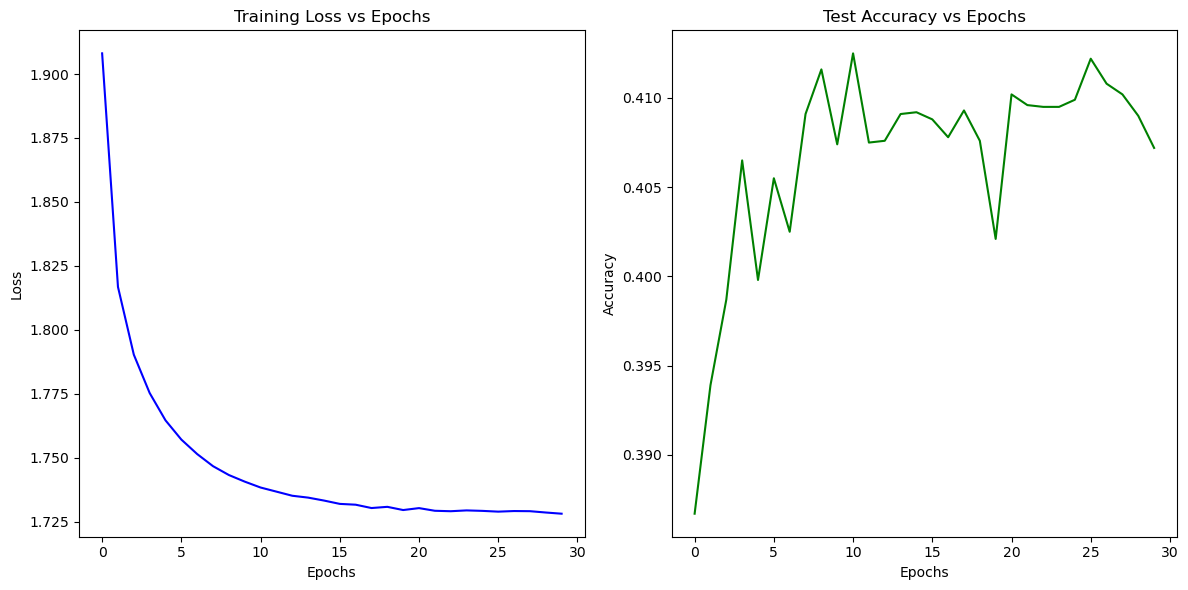

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as npy
# Define image transformation (without data augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standardization
])
# Load CIFAR-10 training and test datasets with transformations
CifartrainingData = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
Cifartest_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Create data loaders for batching
train_loader = DataLoader(CifartrainingData, batch_size=128, shuffle=True)  # Increased batch size
test_loader = DataLoader(Cifartest_data, batch_size=128, shuffle=False)
# Hyperparameters
learning_rate = 0.01  # Keep learning rate as is
epochs = 30  # Increased epochs for better accuracy
regularization_strength = 0.01  # Slightly increased regularization strength
# Define simple linear classifier model
class SimpleLinearClassifier:
    def __init__(self, input_dmen, total_classes, regularization_strength=0.0):
        self.weights = npy.random.randn(input_dmen, total_classes) * 0.01  # Initialize weights
        self.bias = npy.zeros((1, total_classes))  # Initialize bias
        self.reg_strength = regularization_strength  # Regularization parameter
    def forward_pass_method(self, input_X):
        return npy.dot(input_X, self.weights) + self.bias  # input * weight + bias
    def lossComputation(self, logits, labels):
        numSamples = logits.shape[0]
        exp_scoreValues = npy.exp(logits - npy.max(logits, axis=1, keepdims=True))  # Stability adjustment
        probs = exp_scoreValues / npy.sum(exp_scoreValues, axis=1, keepdims=True)  # Softmax
        correct_log_prob = -npy.log(probs[npy.arange(numSamples), labels])
        lossValue = npy.sum(correct_log_prob) / numSamples
        regularization = self.reg_strength * npy.sum(self.weights ** 2)
        lossValue += regularization
        return lossValue, probs
    def backward_function(self, input_X, probs, labels):
        numSamples = input_X.shape[0]
        grads = probs
        grads[npy.arange(numSamples), labels] -= 1
        grads /= numSamples
        gradWeights = npy.dot(input_X.T, grads)
        gradWeights += 2 * self.reg_strength * self.weights
        gradBiasValue = npy.sum(grads, axis=0, keepdims=True)
        return gradWeights, gradBiasValue
    def update(self, gradWeights, gradBiasValue, lr):
        self.weights -= lr * gradWeights
        self.bias -= lr * gradBiasValue
# Initialize the classifier
input_dmen = 32 * 32 * 3  # Image dimensions
total_classes = 10  # CIFAR-10 has 10 classes
classifier = SimpleLinearClassifier(input_dmen, total_classes, regularization_strength)
# Store training loss and test accuracy for plotting
training_losses = []
test_accuracies = []
# Training loop
for epochValue in range(epochs):
    classifier.weights = classifier.weights.astype(npy.float32)  # Ensure float32 type
    epochLossValue = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1).numpy()  # Flatten image batch
        labels = labels.numpy()
        # Forward pass
        logits = classifier.forward_pass_method(images)
        lossValue, probabilities = classifier.lossComputation(logits, labels)
        epochLossValue += lossValue
        # Backward pass
        gradWeights, gradBiasValue = classifier.backward_function(images, probabilities, labels)
        # Parameter update
        classifier.update(gradWeights, gradBiasValue, learning_rate)
    training_losses.append(epochLossValue / len(train_loader))
    # Evaluate on test data
    classifier.weights = classifier.weights.astype(npy.float32)
    test_logits = []
    test_labels = []
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).numpy()  # Flatten image batch
        labels = labels.numpy()
        # Forward pass
        logits = classifier.forward_pass_method(images)
        test_logits.append(logits)
        test_labels.append(labels)
    test_logits = npy.concatenate(test_logits, axis=0)
    test_labels = npy.concatenate(test_labels, axis=0)
    # Calculate accuracy
    predicted_labels = npy.argmax(test_logits, axis=1)
    accuracy = accuracy_score(test_labels, predicted_labels)
    test_accuracies.append(accuracy)
    # Print epoch statistics
    print(f"Epoch {epochValue+1}/{epochs}, Loss: {epochLossValue / len(train_loader):.4f}, Test Accuracy: {accuracy:.4f}")
# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), training_losses, label='Training Loss', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), test_accuracies, label='Test Accuracy', color='g')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()
